In [33]:
import os
import numpy as np
import string
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from scipy.sparse import csr_matrix, hstack
from IPython.display import display

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords


In [34]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [35]:
from keras.layers import Input,Dropout,Dense,BatchNormalization,Activation,concatenate,GRU,Embedding,Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping#, TensorBoard
from keras import backend as K
from keras import optimizers
from keras.optimizers import SGD, Adam
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences

from multiprocessing import Pool

In [36]:
train = pd.read_csv("/home/rajath/Downloads/kaggle/train.csv")
test = pd.read_csv("/home/rajath/Downloads/kaggle/test.csv")


In [37]:
print(test.head())

                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.


In [38]:
print("number of toxic data:{}".format(train.toxic.sum()))
print("number of severe_toxic data:{}".format(train.severe_toxic.sum()))
print("number of obscene data:{}".format(train.obscene.sum()))
print("number of threat data:{}".format(train.threat.sum()))
print("number of insult data:{}".format(train.insult.sum()))
print("number of identity_hate data:{}".format(train.identity_hate.sum()))

number of toxic data:15294
number of severe_toxic data:1595
number of obscene data:8449
number of threat data:478
number of insult data:7877
number of identity_hate data:1405


In [39]:
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punc = set(string.punctuation)

[nltk_data] Downloading package stopwords to /home/rajath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def rmPunc(sent):
    return ' '.join([ch for ch in str(sent) if ch not in punc])
    
def rmStop(sent):
    return ' '.join([word for word in sent.split() if word not in stop])


In [41]:
p = Pool()

%time train.comment_text = p.map(rmPunc,train.comment_text.str.lower())
%time test.comment_text = p.map(rmPunc,test.comment_text.str.lower())

%time train.comment_text = p.map(rmStop,train.comment_text.str.lower())
%time test.comment_text = p.map(rmStop,test.comment_text.str.lower())

CPU times: user 349 ms, sys: 119 ms, total: 468 ms
Wall time: 2.13 s
CPU times: user 300 ms, sys: 127 ms, total: 427 ms
Wall time: 1.89 s
CPU times: user 415 ms, sys: 53.8 ms, total: 469 ms
Wall time: 1.89 s
CPU times: user 388 ms, sys: 64.9 ms, total: 453 ms
Wall time: 1.93 s


In [42]:
from keras.preprocessing.text import Tokenizer

text = np.hstack([train.comment_text.str.lower(),train.comment_text.str.lower()])

tok = Tokenizer()

tok.fit_on_texts(text)

In [43]:
train["input"] = tok.texts_to_sequences(train.comment_text.str.lower())
test["input"] = tok.texts_to_sequences(test.comment_text.str.lower())

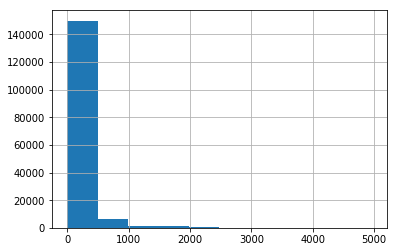

In [44]:
train.input.apply(lambda x:len(x)).hist()

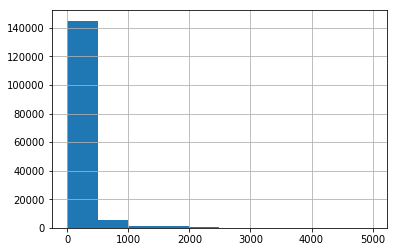

In [45]:
test.input.apply(lambda x:len(x)).hist()

In [46]:
MAX_LENGTH = 200
MAX_TOKEN = np.max([np.max(train.input.max()),np.max(test.input.max())]) + 5

In [47]:
train = train[['input','toxic','severe_toxic','obscene','threat','insult','identity_hate']]
test = test[['input']]
dtrain, dvalid = train_test_split(train,train_size=0.7)


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [58]:
A = Input(shape=[MAX_LENGTH],name="in")
B = Embedding(MAX_TOKEN, 128)(A)
C = GRU(32) (B)
D = Dropout(0.8)(Dense(1024,activation='relu')(C))
E = Dropout(0.8)(Dense(256,activation='relu')(D))
F = Dropout(0.8)(Dense(32,activation='relu')(E))
output  = Dense(6,activation='softmax')(F)


In [59]:
from keras import metrics

model = Model(A, output)
N_epoch = 5
learning_rate = 0.0005
optimizer = Adam(learning_rate)
loss = 'categorical_crossentropy'
metrics = [metrics.categorical_accuracy]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 128)          259584    
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                15456     
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              33792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

In [60]:
print(dtrain)

                                                    input  toxic  \
117074  [11, 1, 5, 5, 4, 1, 3, 5, 11, 4, 6, 8, 7, 1, 2...      0   
61239   [2, 7, 3, 1, 1, 11, 3, 15, 6, 1, 3, 2, 4, 1, 1...      0   
1164    [6, 3, 1, 6, 3, 11, 2, 14, 1, 3, 2, 7, 1, 1, 4...      0   
5130    [2, 8, 2, 9, 4, 1, 3, 4, 1, 2, 1, 14, 1, 3, 8,...      1   
119848  [1, 9, 1, 4, 6, 9, 4, 6, 11, 1, 3, 1, 9, 2, 9,...      0   
55191   [4, 2, 12, 4, 1, 11, 7, 7, 6, 2, 9, 4, 1, 1, 8...      1   
142806  [7, 6, 5, 6, 1, 18, 8, 5, 2, 4, 1, 8, 3, 12, 5...      0   
149452  [10, 3, 1, 7, 6, 1, 1, 12, 1, 6, 2, 1, 3, 4, 1...      1   
44678   [4, 1, 2, 6, 3, 1, 5, 5, 4, 6, 5, 3, 1, 4, 1, ...      0   
159138  [11, 1, 5, 5, 2, 1, 2, 11, 11, 1, 5, 5, 13, 2,...      0   
152658  [13, 9, 1, 4, 1, 12, 3, 7, 5, 6, 2, 9, 1, 3, 6...      0   
121864  [7, 1, 2, 3, 1, 10, 1, 2, 1, 5, 1, 1, 10, 3, 2...      0   
7631    [6, 1, 14, 1, 3, 3, 1, 2, 4, 2, 9, 11, 2, 12, ...      1   
16879   [11, 4, 11, 6, 5, 2, 2, 1, 6, 1, 2, 1, 1

In [61]:
train_x = pad_sequences(dtrain.input,maxlen=MAX_LENGTH)
valid_x = pad_sequences(dvalid.input,maxlen=MAX_LENGTH)
test_x = pad_sequences(test.input,maxlen=MAX_LENGTH)

train_y = dtrain.iloc[:,1:7]
valid_y = dvalid.iloc[:,1:7]

In [62]:
print(train_y.shape)

(111699, 6)


In [63]:
res = model.fit(train_x,train_y,batch_size=128,epochs=N_epoch,validation_data = (valid_x,valid_y))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 182s 2ms/step - loss: 0.3348 - categorical_accuracy: 0.8340 - val_loss: 0.3017 - val_categorical_accuracy: 0.9942
Epoch 2/5
111699/111699 [==============================] - 192s 2ms/step - loss: 0.3121 - categorical_accuracy: 0.9931 - val_loss: 0.3013 - val_categorical_accuracy: 0.9942
Epoch 3/5
111699/111699 [==============================] - 201s 2ms/step - loss: 0.3073 - categorical_accuracy: 0.9941 - val_loss: 0.3008 - val_categorical_accuracy: 0.9942
Epoch 4/5
111699/111699 [==============================] - 207s 2ms/step - loss: 0.3049 - categorical_accuracy: 0.9942 - val_loss: 0.3008 - val_categorical_accuracy: 0.9942
Epoch 5/5
111699/111699 [==============================] - 213s 2ms/step - loss: 0.3035 - categorical_accuracy: 0.9942 - val_loss: 0.3008 - val_categorical_accuracy: 0.9942


In [64]:
test_y = model.predict(test_x)

In [65]:
print(test_y)

[[0.43262306 0.04549582 0.2445976  0.01440529 0.22401938 0.03885879]
 [0.42389545 0.04951083 0.24320422 0.01725154 0.22328527 0.04285269]
 [0.53606    0.01092819 0.23882128 0.00079622 0.20604612 0.00734824]
 ...
 [0.4439453  0.04042303 0.24679512 0.0111402  0.22418419 0.0335122 ]
 [0.52338916 0.01327137 0.24260321 0.00117151 0.21033676 0.00922796]
 [0.41882554 0.05220994 0.24190521 0.01913802 0.22246478 0.0454565 ]]


In [66]:
subm = pd.read_csv('/home/rajath/Downloads/sample_submission.csv')

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [68]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(test_y, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [70]:
logreg = LogisticRegression(C=9.0)
logreg.fit(train_x,train_y)

ValueError: bad input shape (111699, 6)

In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

max_features = 20000
maxlen = 100


train = pd.read_csv("/home/rajath/Downloads/kaggle/train.csv")
test = pd.read_csv("/home/rajath/Downloads/kaggle/test.csv")
train = train.sample(frac=1)

list_sentences_train = train["comment_text"].fillna("CVxTz").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("CVxTz").values


tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


model = get_model()
batch_size = 32
epochs = 2


#file_path="weights_base.best.hdf5"
#checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [early] #early
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)



Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1088s 8ms/step - loss: 0.0625 - acc: 0.9792 - val_loss: 0.0494 - val_acc: 0.9821
Epoch 2/2
143613/143613 [==============================] - 1038s 7ms/step - loss: 0.0452 - acc: 0.9832 - val_loss: 0.0488 - val_acc: 0.9824


In [80]:
#model.load_weights(file_path)

y_test = model.predict(X_te)

FileNotFoundError: File b'/home/rajath/Downloads/sample_submission.csv' does not exist

In [83]:

sample_submission = pd.read_csv("/home/rajath/work/submission.csv")

sample_submission[list_classes] = y_test



sample_submission.to_csv("submissions.csv", index=False)